[[1.15850149e-03 9.85382940e-06 2.23700627e-05 4.44934309e-01
  8.53625708e-04 8.37864168e-03 6.64048246e-04 3.16707474e-06
  4.08711048e-06 5.26960790e-01 2.00156956e-05 5.54376049e-04
  0.00000000e+00 3.26244981e-06 0.00000000e+00 1.30372791e-05
  0.00000000e+00 7.90942833e-03 5.49072183e-06 0.00000000e+00
  4.42464184e-03 4.06516297e-03 0.00000000e+00 5.91562821e-06
  1.37987888e-06 3.62240530e-06 4.36258142e-06]
 [1.88899413e-03 4.97152869e-05 3.85859166e-05 2.92179555e-01
  2.82065501e-03 4.56493907e-03 4.58526716e-04 2.26174288e-05
  1.18399121e-05 6.76736772e-01 7.23569829e-05 2.40975554e-04
  0.00000000e+00 3.04507248e-05 0.00000000e+00 7.75552598e-06
  8.02983436e-07 1.01429066e-02 3.30938565e-05 4.69456063e-06
  7.05597829e-03 3.56586045e-03 0.00000000e+00 3.67789580e-05
  1.99561600e-05 7.74266573e-06 8.44005262e-06]
 [9.75785137e-04 1.76250887e-05 2.04857788e-03 1.57821923e-01
  1.47295371e-03 4.98253806e-03 1.17583164e-04 5.14480143e-06
  1.09831481e-05 8.09577048e-01 6.64

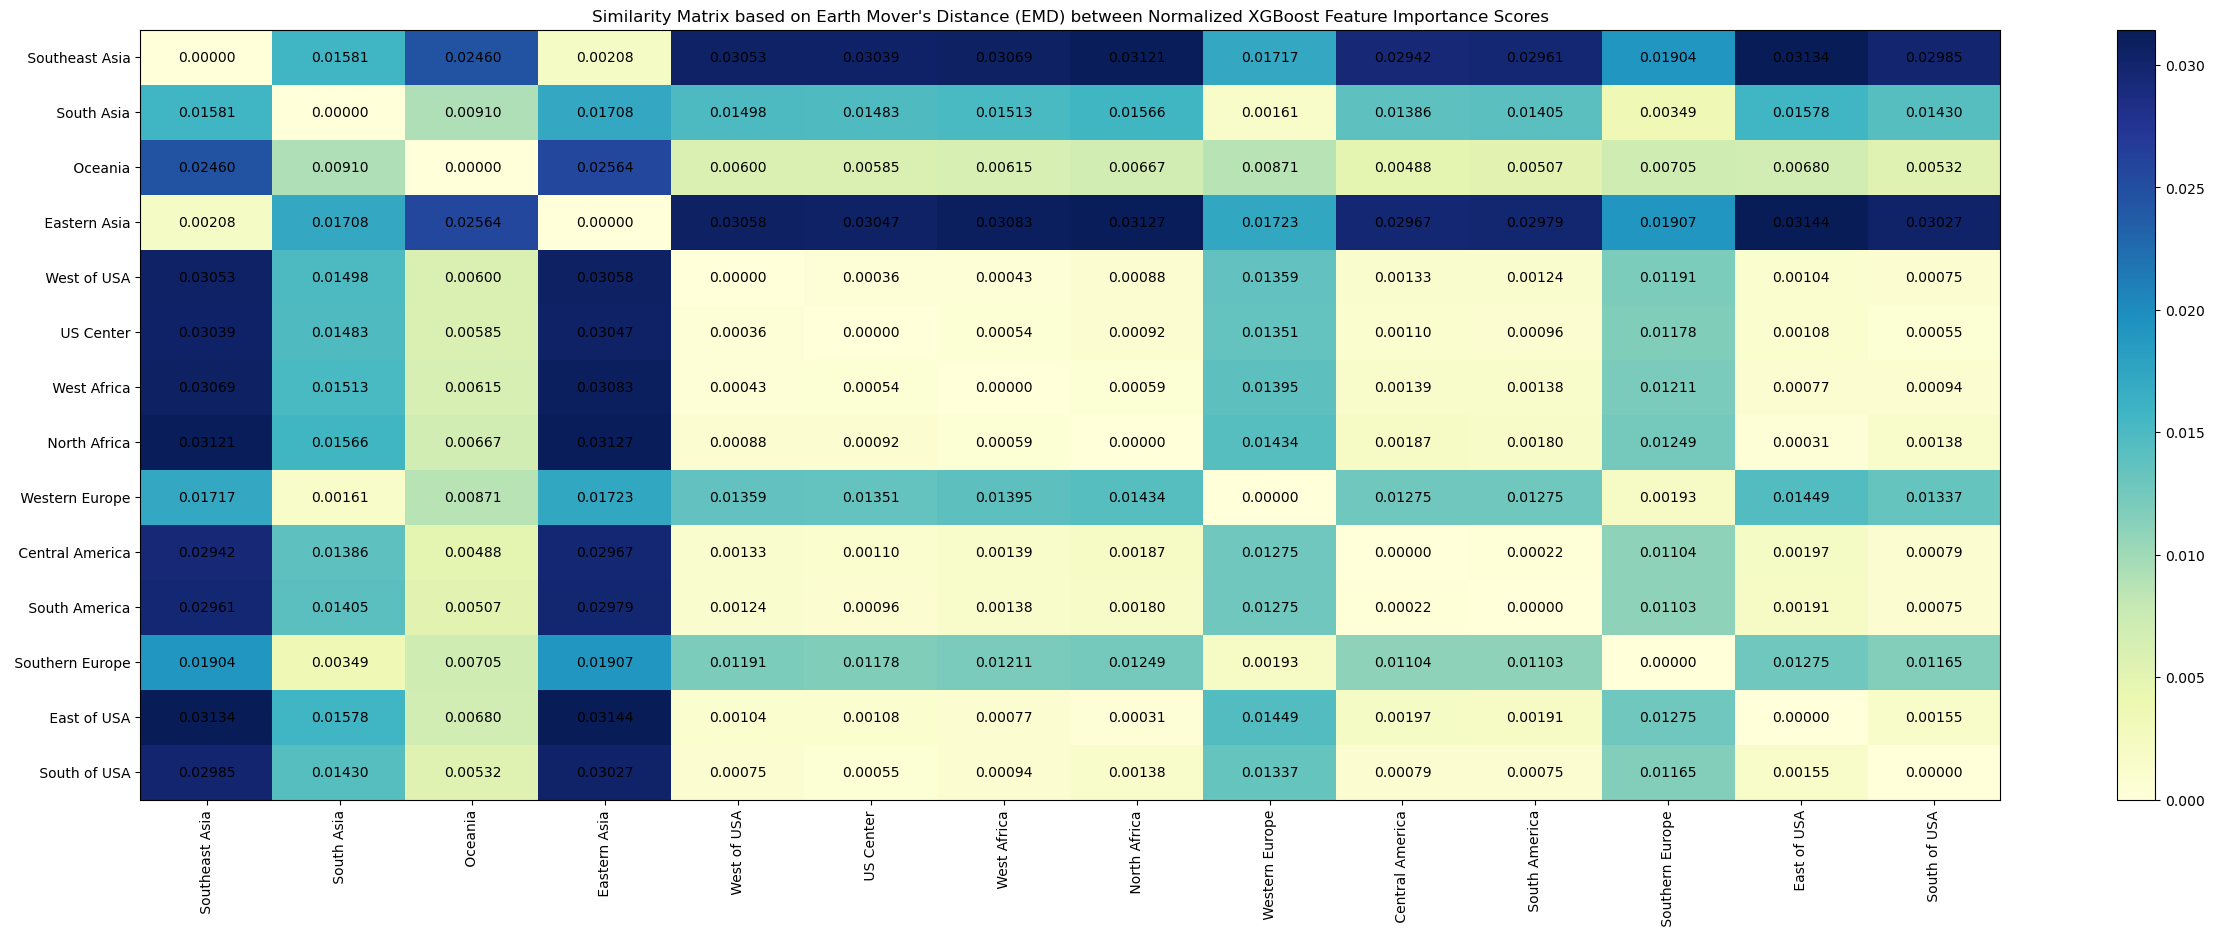

In [23]:
import pandas as pd
from sklearn.metrics import jaccard_score
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import AgglomerativeClustering
import h5py
import xgboost as xgb
from scipy.stats import wasserstein_distance

region_map = {
    0: "Southeast Asia",
    1: "South Asia",
    2: "Oceania",
    3: "Eastern Asia",
    4: "West Asia",
    5: "West of USA",
    6: "US Center",
    7: "West Africa",
    8: "Central Africa",
    9: "North Africa",
    10: "Western Europe",
    11: "Northern Europe",
    12: "Central America",
    13: "Caribbean",
    14: "South America",
    15: "East Africa",
    16: "Southern Europe",
    17: "East of USA",
    18: "Canada",
    19: "Southern Africa",
    20: "Central Asia",
    21: "Eastern Europe",
    22: "South of USA",
}

sheet_names = ['0', '1', '2', '3', '5', '6', '7', '9', '10', '12', '14', '16', '17', '22']
dataframes = []

file = h5py.File("market_data.h5", "r")

for sheet_name in sheet_names:

    dataset = file[sheet_name][:]
    dataset = pd.DataFrame(dataset)
    column_names = file[sheet_name].attrs["columns"]
    dataset.columns = column_names
    dataframes.append(dataset)

df = pd.concat(dataframes, ignore_index=True)
df.rename(columns={"Region Index": "Order Region"}, inplace=True)
df["Order Region"] = df["Order Region"].map(region_map)

def calculate_emd(distribution1, distribution2):
    return wasserstein_distance(distribution1, distribution2)

feature_importance_scores = []
df_cluster = df.copy()

for region in df_cluster['Order Region'].unique():
    # Create subset DataFrame for the current Order Region
    subset_df = df_cluster[df_cluster['Order Region'] == region].drop(columns=['Order Region'])

    y = subset_df['Sales'].values

    X = subset_df.drop(columns=['Sales']).values

    model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)
    model.fit(X, y)

    feature_importance_scores.append(model.feature_importances_)

feature_importance_scores = np.array(feature_importance_scores)
print(feature_importance_scores)

num_regions = len(feature_importance_scores)

similarity_matrix_xgboost = np.zeros((num_regions, num_regions))

reverse_mapping = {v: k for k, v in region_map.items()}

region_names = []

for i, region in enumerate(df_cluster['Order Region'].unique()):
    region_names.append(region_map.get(region, f' {region}'))

# Function to normalize feature importance scores
def normalize_feature_importance(feature_importance_scores):
    max_scores = np.max(feature_importance_scores, axis=1)
    normalized_scores = feature_importance_scores / max_scores[:, np.newaxis]
    return normalized_scores

# Normalize feature importance scores
normalized_feature_importance = normalize_feature_importance(feature_importance_scores)
print(normalized_feature_importance.shape)

# Calculate similarity matrix using Earth Mover's Distance
for i in range(num_regions):
    for j in range(i + 1, num_regions):
        emd_value = calculate_emd(normalized_feature_importance[i], normalized_feature_importance[j])
        similarity_matrix_xgboost[i, j] = emd_value
        similarity_matrix_xgboost[j, i] = emd_value

plt.figure(figsize=(30, 10))
plt.imshow(similarity_matrix_xgboost, cmap="YlGnBu", interpolation='nearest', aspect='auto')

for i in range(len(region_names)):
    for j in range(len(region_names)):
        plt.text(j, i, f'{similarity_matrix_xgboost[i, j]:.5f}', ha='center', va='center', color='black')

plt.colorbar()
plt.title('Similarity Matrix based on Earth Mover\'s Distance (EMD) between Normalized XGBoost Feature Importance Scores')
plt.xticks(np.arange(len(region_names)), region_names, rotation=90)
plt.yticks(np.arange(len(region_names)), region_names)
plt.show()


# agglomerative clustering

In [28]:
from sklearn.metrics.pairwise import pairwise_distances
from scipy.cluster.hierarchy import linkage, fcluster
from scipy.stats import wasserstein_distance
from sklearn.cluster import KMeans

# Normalize feature importance scores
normalized_feature_importance = normalize_feature_importance(feature_importance_scores)

# Calculate pairwise EMD distances
emd_distances = pairwise_distances(normalized_feature_importance, metric=calculate_emd)

# Calculate linkage matrix using EMD distances
linkage_matrix = linkage(emd_distances, method='average')  # You can adjust the method as desired

# Perform agglomerative clustering
num_clusters = 14  # Set the number of clusters as desired
cluster_labels = fcluster(linkage_matrix, num_clusters, criterion='maxclust')

# Print cluster labels for each region
for region, label in zip(region_names, cluster_labels):
    print(f"Region: {region}, Cluster: {label}")

Region:  Southeast Asia, Cluster: 1
Region:  South Asia, Cluster: 3
Region:  Oceania, Cluster: 12
Region:  Eastern Asia, Cluster: 2
Region:  West of USA, Cluster: 9
Region:  US Center, Cluster: 10
Region:  West Africa, Cluster: 11
Region:  North Africa, Cluster: 8
Region:  Western Europe, Cluster: 4
Region:  Central America, Cluster: 6
Region:  South America, Cluster: 6
Region:  Southern Europe, Cluster: 5
Region:  East of USA, Cluster: 8
Region:  South of USA, Cluster: 7


/var/folders/_y/0xw7_0ss0s3f4kfhj9xl96zw0000gn/T/ipykernel_51063/1157086077.py:13: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage_matrix = linkage(emd_distances, method='average')  # You can adjust the method as desired


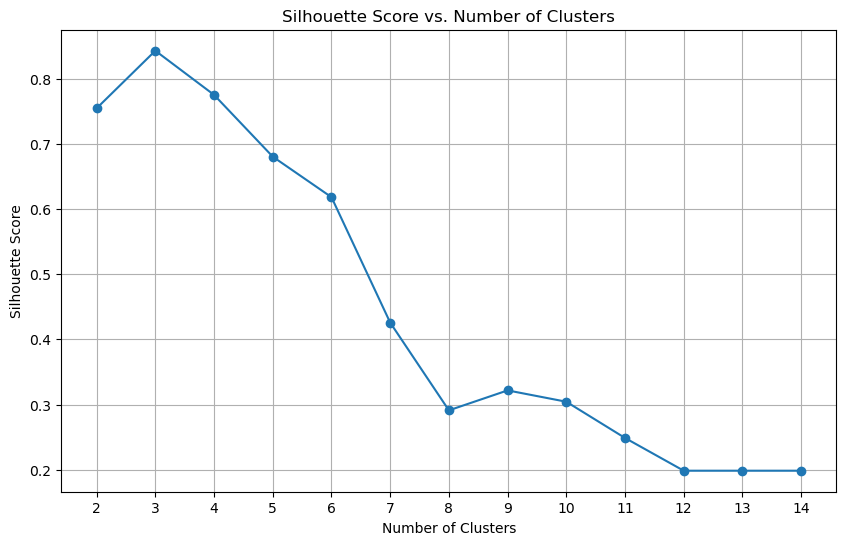

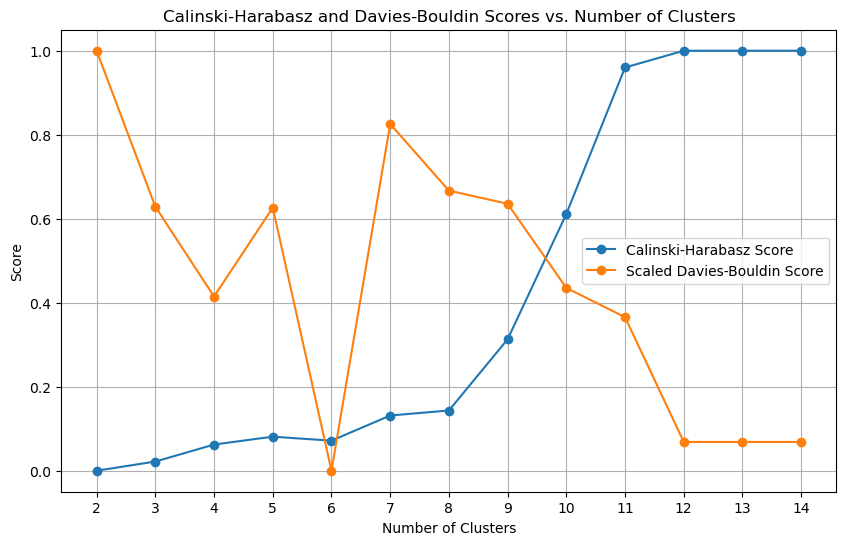

In [3]:
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

# Initialize lists to store silhouette scores and other metrics
silhouette_scores = []
calinski_harabasz_scores = []
davies_bouldin_scores = []

# Range of number of clusters to evaluate
num_clusters_range = range(2, 15)

for num_clusters in num_clusters_range:
    # Perform agglomerative clustering
    cluster_labels = fcluster(linkage_matrix, num_clusters, criterion='maxclust')
    
    # Calculate silhouette score
    silhouette = silhouette_score(emd_distances, cluster_labels)
    silhouette_scores.append(silhouette)
    
    # Calculate Calinski-Harabasz score
    ch_score = calinski_harabasz_score(emd_distances, cluster_labels)
    calinski_harabasz_scores.append(ch_score)
    
    # Calculate Davies-Bouldin score
    db_score = davies_bouldin_score(emd_distances, cluster_labels)
    davies_bouldin_scores.append(db_score)

# Plotting silhouette score
plt.figure(figsize=(10, 6))
plt.plot(num_clusters_range, silhouette_scores, marker='o')
plt.title('Silhouette Score vs. Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.xticks(num_clusters_range)
plt.grid(True)
plt.show()

# Scale Davies-Bouldin scores
scaler = MinMaxScaler()
davies_bouldin_scores_scaled = scaler.fit_transform(np.array(davies_bouldin_scores).reshape(-1, 1)).flatten()
calinski_harabasz_scores = scaler.fit_transform(np.array(calinski_harabasz_scores).reshape(-1, 1)).flatten()

# Plotting both evaluation metrics
plt.figure(figsize=(10, 6))
plt.plot(num_clusters_range, calinski_harabasz_scores, marker='o', label='Calinski-Harabasz Score')
plt.plot(num_clusters_range, davies_bouldin_scores_scaled, marker='o', label='Scaled Davies-Bouldin Score')
plt.title('Calinski-Harabasz and Davies-Bouldin Scores vs. Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.xticks(num_clusters_range)
plt.legend()
plt.grid(True)
plt.show()


# you may prioritize metrics that measure the coherence and separability of the clusters, such as silhouette score, Calinski-Harabasz index, or Davies-Bouldin index.
Use the Silhouette Score when you want to evaluate the overall quality and separation of clusters, especially if you have well-separated clusters.
Use the Davies-Bouldin Index when you want to minimize the average similarity between clusters, especially if you have non-convex or irregularly shaped clusters.

#
Silhouette Score: Silhouette score measures how similar an object is to its own cluster (cohesion) compared to other clusters (separation). It ranges from -1 to 1, where a high value indicates that the object is well-matched to its own cluster and poorly matched to neighboring clusters. Silhouette score is useful when you want to evaluate the quality and separation of individual clusters. It's generally preferred when the clusters are well-separated and have a roughly equal number of samples.



Davies-Bouldin Index: The Davies-Bouldin index measures the average similarity between each cluster and its most similar cluster, where similarity is defined based on the ratio of within-cluster scatter to between-cluster separation. A lower Davies-Bouldin index indicates better clustering, with values closer to zero indicating better separation. This index is useful when you want to minimize the average similarity between clusters.

# Differencial Privacy

In [29]:
import numpy as np
from scipy.cluster.hierarchy import linkage, fcluster
from sklearn.metrics.pairwise import pairwise_distances
from scipy.stats import wasserstein_distance
from sklearn.cluster import KMeans

# Function to add Laplace noise to each subarray
def add_laplace_noise_to_subarrays(array, sensitivity, epsilon):
    noisy_array = np.zeros_like(array)
    for i, subarray in enumerate(array):
        scale = sensitivity / epsilon
        noise = np.random.laplace(loc=0.0, scale=scale, size=subarray.shape)
        noisy_array[i] = subarray + noise
    return noisy_array

# Function to calculate Earth Mover's Distance using Wasserstein distance
def calculate_emd(distribution1, distribution2):
    return wasserstein_distance(distribution1, distribution2)

# Define sensitivity and epsilon as before
sensitivity = 0.01
epsilon_feature_importance = 1

# Add Laplace noise to each subarray
noisy_subarrays = [add_laplace_noise_to_subarrays(subarray, sensitivity, epsilon_feature_importance) 
                   for subarray in normalized_feature_importance]

# Calculate pairwise EMD distances with noisy feature importance scores
emd_distances_noisy = pairwise_distances(noisy_subarrays, metric=calculate_emd)

# Calculate linkage matrix using noisy EMD distances
linkage_matrix = linkage(emd_distances_noisy, method='average')  # You can adjust the method as desired

# Perform agglomerative clustering
num_clusters = 13  # Set the number of clusters as desired
cluster_labels = fcluster(linkage_matrix, num_clusters, criterion='maxclust')

# Print cluster labels for each region
for region, label in zip(region_names, cluster_labels):
    print(f"Region: {region}, Cluster: {label}")


Region:  Southeast Asia, Cluster: 1
Region:  South Asia, Cluster: 3
Region:  Oceania, Cluster: 12
Region:  Eastern Asia, Cluster: 2
Region:  West of USA, Cluster: 8
Region:  US Center, Cluster: 10
Region:  West Africa, Cluster: 6
Region:  North Africa, Cluster: 7
Region:  Western Europe, Cluster: 4
Region:  Central America, Cluster: 7
Region:  South America, Cluster: 9
Region:  Southern Europe, Cluster: 5
Region:  East of USA, Cluster: 6
Region:  South of USA, Cluster: 11


/var/folders/_y/0xw7_0ss0s3f4kfhj9xl96zw0000gn/T/ipykernel_51063/1148234612.py:32: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage_matrix = linkage(emd_distances_noisy, method='average')  # You can adjust the method as desired


# DP

[[1.15850149e-03 9.85382940e-06 2.23700627e-05 4.44934309e-01
  8.53625708e-04 8.37864168e-03 6.64048246e-04 3.16707474e-06
  4.08711048e-06 5.26960790e-01 2.00156956e-05 5.54376049e-04
  0.00000000e+00 3.26244981e-06 0.00000000e+00 1.30372791e-05
  0.00000000e+00 7.90942833e-03 5.49072183e-06 0.00000000e+00
  4.42464184e-03 4.06516297e-03 0.00000000e+00 5.91562821e-06
  1.37987888e-06 3.62240530e-06 4.36258142e-06]
 [1.88899413e-03 4.97152869e-05 3.85859166e-05 2.92179555e-01
  2.82065501e-03 4.56493907e-03 4.58526716e-04 2.26174288e-05
  1.18399121e-05 6.76736772e-01 7.23569829e-05 2.40975554e-04
  0.00000000e+00 3.04507248e-05 0.00000000e+00 7.75552598e-06
  8.02983436e-07 1.01429066e-02 3.30938565e-05 4.69456063e-06
  7.05597829e-03 3.56586045e-03 0.00000000e+00 3.67789580e-05
  1.99561600e-05 7.74266573e-06 8.44005262e-06]
 [9.75785137e-04 1.76250887e-05 2.04857788e-03 1.57821923e-01
  1.47295371e-03 4.98253806e-03 1.17583164e-04 5.14480143e-06
  1.09831481e-05 8.09577048e-01 6.64

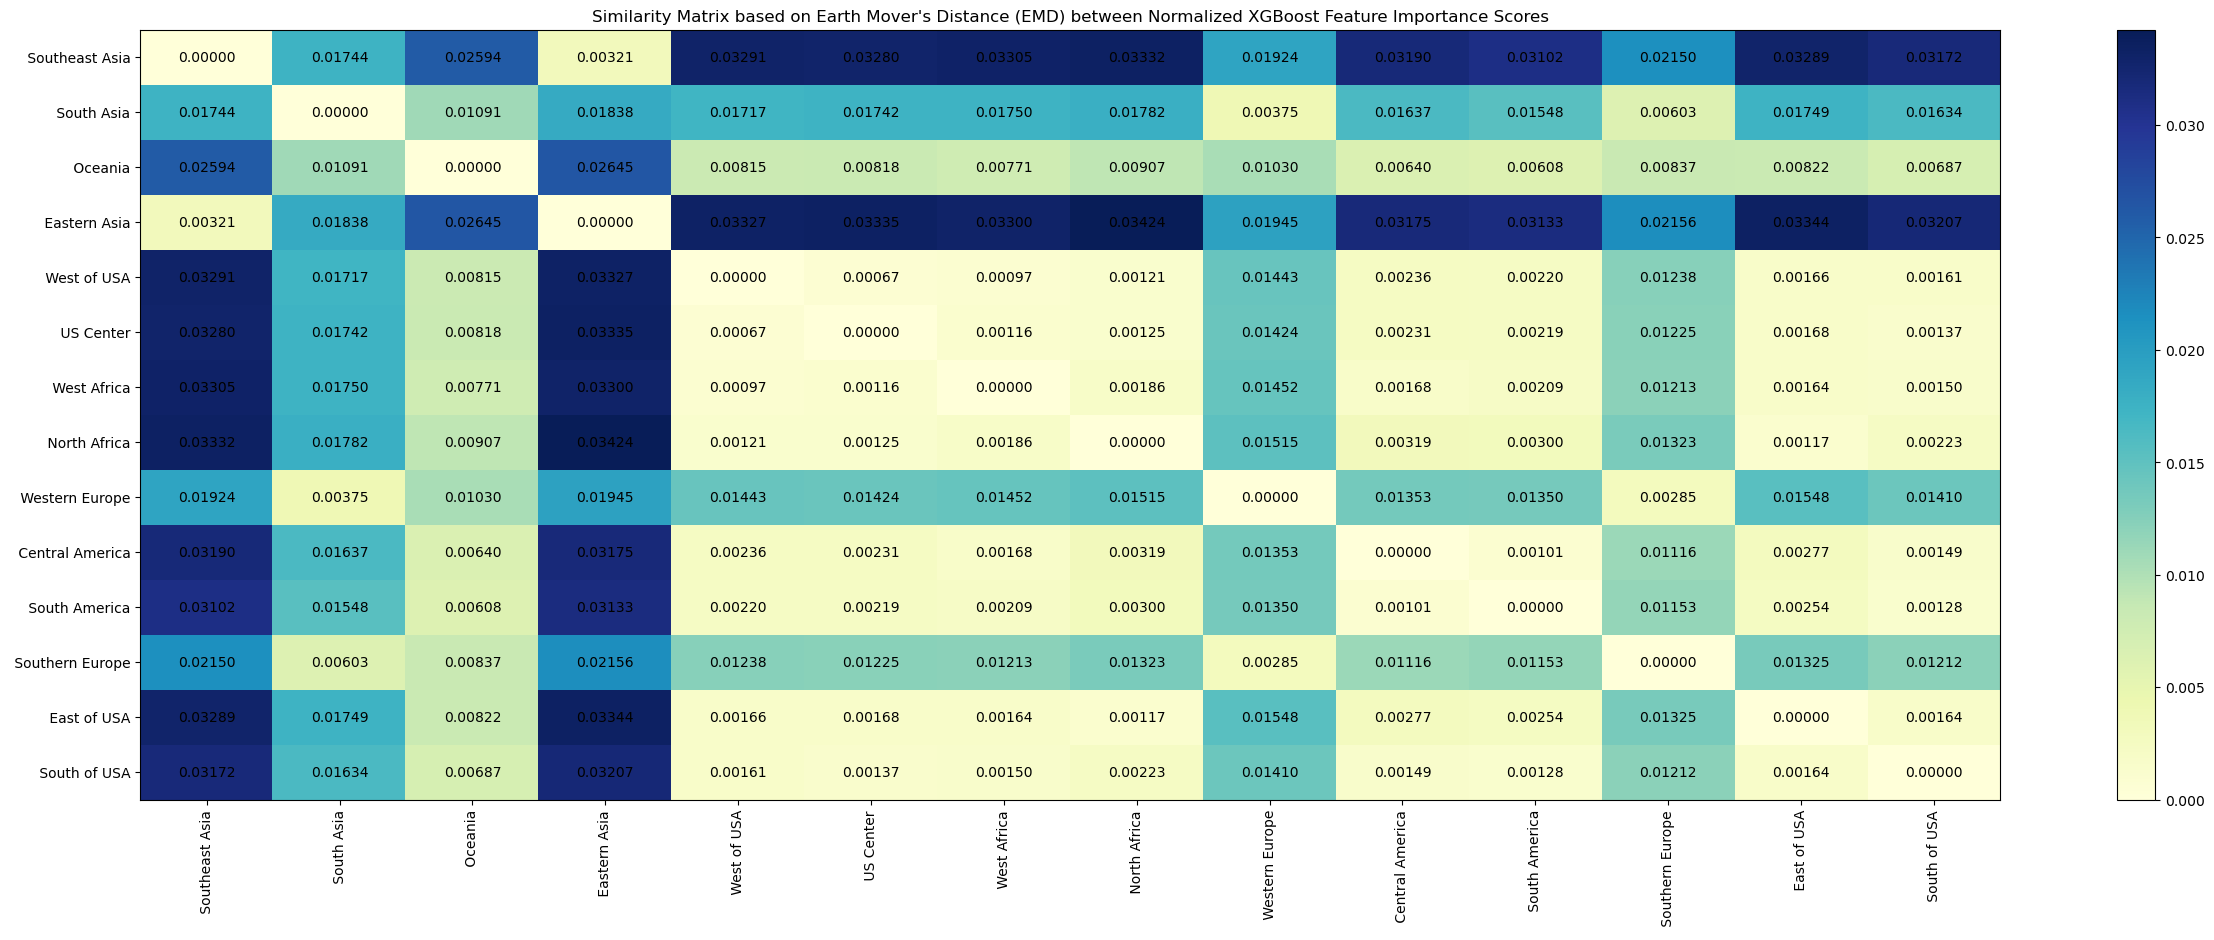

In [30]:
import pandas as pd
from sklearn.metrics import jaccard_score
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import AgglomerativeClustering
import h5py
import xgboost as xgb
from scipy.stats import wasserstein_distance

region_map = {
    0: "Southeast Asia",
    1: "South Asia",
    2: "Oceania",
    3: "Eastern Asia",
    4: "West Asia",
    5: "West of USA",
    6: "US Center",
    7: "West Africa",
    8: "Central Africa",
    9: "North Africa",
    10: "Western Europe",
    11: "Northern Europe",
    12: "Central America",
    13: "Caribbean",
    14: "South America",
    15: "East Africa",
    16: "Southern Europe",
    17: "East of USA",
    18: "Canada",
    19: "Southern Africa",
    20: "Central Asia",
    21: "Eastern Europe",
    22: "South of USA",
}

sheet_names = ['0', '1', '2', '3', '5', '6', '7', '9', '10', '12', '14', '16', '17', '22']
dataframes = []

file = h5py.File("market_data.h5", "r")

for sheet_name in sheet_names:

    dataset = file[sheet_name][:]
    dataset = pd.DataFrame(dataset)
    column_names = file[sheet_name].attrs["columns"]
    dataset.columns = column_names
    dataframes.append(dataset)

df = pd.concat(dataframes, ignore_index=True)
df.rename(columns={"Region Index": "Order Region"}, inplace=True)
df["Order Region"] = df["Order Region"].map(region_map)

def calculate_emd(distribution1, distribution2):
    return wasserstein_distance(distribution1, distribution2)

feature_importance_scores = []
df_cluster = df.copy()

for region in df_cluster['Order Region'].unique():
    # Create subset DataFrame for the current Order Region
    subset_df = df_cluster[df_cluster['Order Region'] == region].drop(columns=['Order Region'])

    y = subset_df['Sales'].values

    X = subset_df.drop(columns=['Sales']).values

    model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)
    model.fit(X, y)

    feature_importance_scores.append(model.feature_importances_)

feature_importance_scores = np.array(feature_importance_scores)
print(feature_importance_scores)

num_regions = len(feature_importance_scores)

similarity_matrix_xgboost = np.zeros((num_regions, num_regions))

reverse_mapping = {v: k for k, v in region_map.items()}

region_names = []

for i, region in enumerate(df_cluster['Order Region'].unique()):
    region_names.append(region_map.get(region, f' {region}'))




import numpy as np
from scipy.cluster.hierarchy import linkage, fcluster
from sklearn.metrics.pairwise import pairwise_distances
from scipy.stats import wasserstein_distance
from sklearn.cluster import KMeans

# Function to add Laplace noise to each subarray
def add_laplace_noise_to_subarrays(array, sensitivity, epsilon):
    noisy_array = np.zeros_like(array)
    for i, subarray in enumerate(array):
        scale = sensitivity / epsilon
        noise = np.random.laplace(loc=0.0, scale=scale, size=subarray.shape)
        noisy_array[i] = subarray + noise
    return noisy_array

# Function to calculate Earth Mover's Distance using Wasserstein distance
def calculate_emd(distribution1, distribution2):
    return wasserstein_distance(distribution1, distribution2)

# Define sensitivity and epsilon as before
sensitivity = 0.01
epsilon = 5

best_epsilon = None
best_cluster_labels = None
best_silhouette_score = float('-inf')



print(feature_importance_scores.shape)

noisy_subarrays = [add_laplace_noise_to_subarrays(subarray, sensitivity, epsilon) 
                    for subarray in feature_importance_scores]

def normalize_feature_importance(feature_importance_scores):
    max_scores = np.max(feature_importance_scores, axis=1)
    normalized_scores = feature_importance_scores / max_scores[:, np.newaxis]
    return normalized_scores


noisy_subarrays = normalize_feature_importance(noisy_subarrays)

# Calculate similarity matrix using Earth Mover's Distance
for i in range(num_regions):
    for j in range(i + 1, num_regions):
        emd_value = calculate_emd(noisy_subarrays[i], noisy_subarrays[j])
        similarity_matrix_xgboost[i, j] = emd_value
        similarity_matrix_xgboost[j, i] = emd_value

plt.figure(figsize=(30, 10))
plt.imshow(similarity_matrix_xgboost, cmap="YlGnBu", interpolation='nearest', aspect='auto')

for i in range(len(region_names)):
    for j in range(len(region_names)):
        plt.text(j, i, f'{similarity_matrix_xgboost[i, j]:.5f}', ha='center', va='center', color='black')

plt.colorbar()
plt.title('Similarity Matrix based on Earth Mover\'s Distance (EMD) between Normalized XGBoost Feature Importance Scores')
plt.xticks(np.arange(len(region_names)), region_names, rotation=90)
plt.yticks(np.arange(len(region_names)), region_names)
plt.show()


In [6]:
region_map = {
    0: "Southeast Asia",
    1: "South Asia",
    2: "Oceania",
    3: "Eastern Asia",
    4: "West Asia",
    5: "West of USA",
    6: "US Center",
    7: "West Africa",
    8: "Central Africa",
    9: "North Africa",
    10: "Western Europe",
    11: "Northern Europe",
    12: "Central America",
    13: "Caribbean",
    14: "South America",
    15: "East Africa",
    16: "Southern Europe",
    17: "East of USA",
    18: "Canada",
    19: "Southern Africa",
    20: "Central Asia",
    21: "Eastern Europe",
    22: "South of  USA",
}

sheet_names = ['0', '1', '2', '3', '5', '6', '7', '9', '10', '12', '14', '16', '17', '22']

region_names = [region_map[int(sheet_name)] for sheet_name in sheet_names]
region_names_tuple = tuple(region_names)

print(region_names_tuple)

('Southeast Asia', 'South Asia', 'Oceania', 'Eastern Asia', 'West of USA', 'US Center', 'West Africa', 'North Africa', 'Western Europe', 'Central America', 'South America', 'Southern Europe', 'East of USA', 'South of  USA')


In [31]:
from sklearn.metrics.pairwise import pairwise_distances
from scipy.cluster.hierarchy import linkage, fcluster
from scipy.stats import wasserstein_distance
from sklearn.cluster import KMeans


# Calculate pairwise EMD distances
emd_distances = pairwise_distances(noisy_subarrays, metric=calculate_emd)

# Calculate linkage matrix using EMD distances
linkage_matrix = linkage(emd_distances, method='average')  # You can adjust the method as desired

# Perform agglomerative clustering
num_clusters =13  # Set the number of clusters as desired
cluster_labels = fcluster(linkage_matrix, num_clusters, criterion='maxclust')

# Print cluster labels for each region
for region, label in zip(region_names, cluster_labels):
    print(f"Region: {region}, Cluster: {label}")

Region:  Southeast Asia, Cluster: 1
Region:  South Asia, Cluster: 5
Region:  Oceania, Cluster: 12
Region:  Eastern Asia, Cluster: 2
Region:  West of USA, Cluster: 9
Region:  US Center, Cluster: 9
Region:  West Africa, Cluster: 9
Region:  North Africa, Cluster: 10
Region:  Western Europe, Cluster: 3
Region:  Central America, Cluster: 6
Region:  South America, Cluster: 7
Region:  Southern Europe, Cluster: 4
Region:  East of USA, Cluster: 11
Region:  South of USA, Cluster: 8


/var/folders/_y/0xw7_0ss0s3f4kfhj9xl96zw0000gn/T/ipykernel_51063/1774384875.py:11: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage_matrix = linkage(emd_distances, method='average')  # You can adjust the method as desired


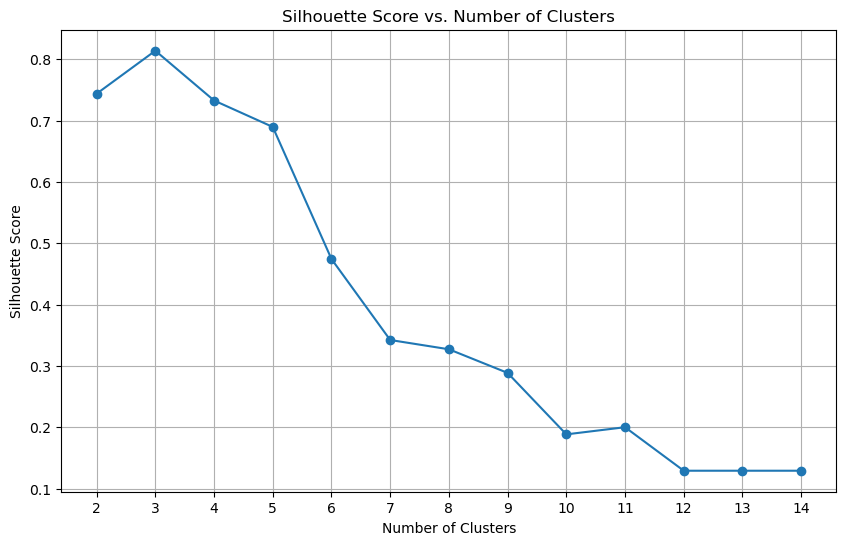

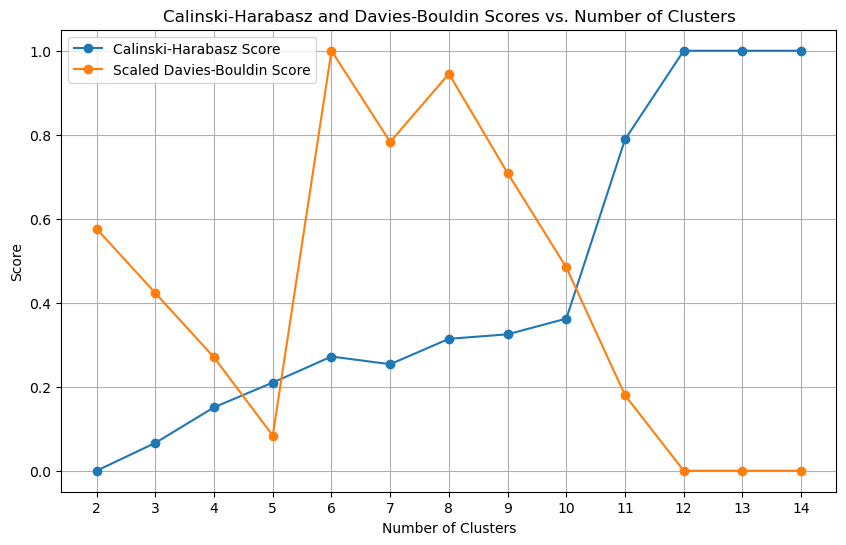

In [13]:
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

# Initialize lists to store silhouette scores and other metrics
silhouette_scores = []
calinski_harabasz_scores = []
davies_bouldin_scores = []

# Range of number of clusters to evaluate
num_clusters_range = range(2, 15)

for num_clusters in num_clusters_range:
    # Perform agglomerative clustering
    cluster_labels = fcluster(linkage_matrix, num_clusters, criterion='maxclust')
    
    # Calculate silhouette score
    silhouette = silhouette_score(emd_distances, cluster_labels)
    silhouette_scores.append(silhouette)
    
    # Calculate Calinski-Harabasz score
    ch_score = calinski_harabasz_score(emd_distances, cluster_labels)
    calinski_harabasz_scores.append(ch_score)
    
    # Calculate Davies-Bouldin score
    db_score = davies_bouldin_score(emd_distances, cluster_labels)
    davies_bouldin_scores.append(db_score)

# Plotting silhouette score
plt.figure(figsize=(10, 6))
plt.plot(num_clusters_range, silhouette_scores, marker='o')
plt.title('Silhouette Score vs. Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.xticks(num_clusters_range)
plt.grid(True)
plt.show()

# Scale Davies-Bouldin scores
scaler = MinMaxScaler()
davies_bouldin_scores_scaled = scaler.fit_transform(np.array(davies_bouldin_scores).reshape(-1, 1)).flatten()
calinski_harabasz_scores = scaler.fit_transform(np.array(calinski_harabasz_scores).reshape(-1, 1)).flatten()

# Plotting both evaluation metrics
plt.figure(figsize=(10, 6))
plt.plot(num_clusters_range, calinski_harabasz_scores, marker='o', label='Calinski-Harabasz Score')
plt.plot(num_clusters_range, davies_bouldin_scores_scaled, marker='o', label='Scaled Davies-Bouldin Score')
plt.title('Calinski-Harabasz and Davies-Bouldin Scores vs. Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.xticks(num_clusters_range)
plt.legend()
plt.grid(True)
plt.show()


In [34]:
import numpy as np
from scipy.cluster.hierarchy import linkage, fcluster
from sklearn.metrics.pairwise import pairwise_distances
from scipy.stats import wasserstein_distance
from sklearn.cluster import KMeans

# Function to add Laplace noise to each subarray
def add_laplace_noise_to_subarrays(array, sensitivity, epsilon):
    noisy_array = np.zeros_like(array)
    for i, subarray in enumerate(array):
        scale = sensitivity / epsilon
        noise = np.random.laplace(loc=0.0, scale=scale, size=subarray.shape)
        noisy_array[i] = subarray + noise
    return noisy_array

# Function to calculate Earth Mover's Distance using Wasserstein distance
def calculate_emd(distribution1, distribution2):
    return wasserstein_distance(distribution1, distribution2)

# Define sensitivity and epsilon as before
sensitivity = 0.01
epsilon_range = [i / 100 for i in range(1, 10000, 1)]

best_epsilon = None
best_cluster_labels = None
best_silhouette_score = float('-inf')

# Iterate over epsilon values
for epsilon in epsilon_range:
    # Add Laplace noise to each subarray
    noisy_subarrays = [add_laplace_noise_to_subarrays(subarray, sensitivity, epsilon) 
                       for subarray in normalized_feature_importance]
    
    # Calculate pairwise EMD distances with noisy feature importance scores
    emd_distances_noisy = pairwise_distances(noisy_subarrays, metric=calculate_emd)

    # Calculate linkage matrix using noisy EMD distances
    linkage_matrix = linkage(emd_distances_noisy, method='average')

    # Perform agglomerative clustering
    num_clusters = 2
    cluster_labels = fcluster(linkage_matrix, num_clusters, criterion='maxclust')

    # Evaluate clustering quality
    from sklearn.metrics import silhouette_score
    silhouette_score_value = silhouette_score(noisy_subarrays, cluster_labels)
    
    # # Print epsilon and clustering quality
    # print(f"Epsilon: {epsilon}, Silhouette Score: {silhouette_score_value}")

    # Update best epsilon and clustering quality if improved
    if silhouette_score_value > best_silhouette_score:
        best_epsilon = epsilon
        best_cluster_labels = cluster_labels
        best_silhouette_score = silhouette_score_value

# Print the best epsilon and corresponding cluster labels
print(f"Best Epsilon: {best_epsilon}, Best Silhouette Score: {best_silhouette_score}")

# Print cluster labels for each region
for region, label in zip(region_names, best_cluster_labels):
    print(f"Region: {region}, Cluster: {label}")


/var/folders/_y/0xw7_0ss0s3f4kfhj9xl96zw0000gn/T/ipykernel_51063/3304312300.py:38: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage_matrix = linkage(emd_distances_noisy, method='average')
/var/folders/_y/0xw7_0ss0s3f4kfhj9xl96zw0000gn/T/ipykernel_51063/3304312300.py:38: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage_matrix = linkage(emd_distances_noisy, method='average')
/var/folders/_y/0xw7_0ss0s3f4kfhj9xl96zw0000gn/T/ipykernel_51063/3304312300.py:38: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage_matrix = linkage(emd_distances_noisy, method='average')
/var/folders/_y/0xw7_0ss0s3f4kfhj9xl96zw0000gn/T/ipykernel_51063/3304312300.py:38: ClusterWarning: scipy.cluster: The symmetric non-nega

Best Epsilon: 14.59, Best Silhouette Score: 0.4893968105316162
Region:  Southeast Asia, Cluster: 1
Region:  South Asia, Cluster: 2
Region:  Oceania, Cluster: 2
Region:  Eastern Asia, Cluster: 1
Region:  West of USA, Cluster: 2
Region:  US Center, Cluster: 2
Region:  West Africa, Cluster: 2
Region:  North Africa, Cluster: 2
Region:  Western Europe, Cluster: 2
Region:  Central America, Cluster: 2
Region:  South America, Cluster: 2
Region:  Southern Europe, Cluster: 2
Region:  East of USA, Cluster: 2
Region:  South of USA, Cluster: 2


/var/folders/_y/0xw7_0ss0s3f4kfhj9xl96zw0000gn/T/ipykernel_51063/3304312300.py:38: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage_matrix = linkage(emd_distances_noisy, method='average')
/var/folders/_y/0xw7_0ss0s3f4kfhj9xl96zw0000gn/T/ipykernel_51063/3304312300.py:38: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage_matrix = linkage(emd_distances_noisy, method='average')
/var/folders/_y/0xw7_0ss0s3f4kfhj9xl96zw0000gn/T/ipykernel_51063/3304312300.py:38: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage_matrix = linkage(emd_distances_noisy, method='average')
/var/folders/_y/0xw7_0ss0s3f4kfhj9xl96zw0000gn/T/ipykernel_51063/3304312300.py:38: ClusterWarning: scipy.cluster: The symmetric non-nega